# Preprocesamiento de Datos

El preprocesamiento de datos - a veces también conocido como transformación de datos o, incluso, ingeniería de atributos - es probablemente una de las parte más importante del trabajo del Data Scientist, tal vez la más importante. Como habrás visto en la bitácora, son muchos los pasos involucrados en este proceso, y eso que no los hemos mencionados a todos, pero sí los más importantes. En este notebook, trabajaremos sobre cuatro grandes áreas:

1. Valores Faltantes
2. Valores Atípicos
3. Escalado de Datos
4. Encoders

Como este notebook corresponde a dos bitácoras y encuentros (19 y 20), no te preocupes si todavía no sabes de qué se tratan los puntos 3 y 4.

Antes de arrancar, una pregunta usual que suele surgir es si usar Pandas o Scikit-Learn, ya que algunos de estos pasos pueden hacerse indistintamente con cualquiera de las dos librerías. Como siempre, la respuesta depende de lo que quieras hacer - y también con cuál herramienta te sientas más cómodo/a. Pero una respuesta rápida es que si estas explorando datos, mejor usar Pandas. Si estás en un flujo de Machine Learning, Scikit-Learn. Probablemente, termines usando las dos en un mismo notebook.

#### Algunas referencias

**Muy útil:** [documentación de Scikit-Learn sobre preprocesamiento de datos](https://scikit-learn.org/stable/modules/preprocessing.html)

**Valores Faltantes**

* En Pandas, explora las funcionalidades `isna()`, `dropna()` y `fillna()`.
* En Scikit-Learn, explora la clase `SimpleImputer`.

**Valores Atípicos**

* Para aplicar los criterios que mencionamos, bastará usar las técnicas de visualización que ya conoces, calcular percentiles, promedios y desviaciones estándar con NumPy o Pandas, y usar máscaras.
* En Scikit-Learn existen métodos para trabajar con valores atípicos. Si bien no los utilizaremos, no está demás si quieres mirarlos [aquí](https://scikit-learn.org/stable/modules/outlier_detection.html).

**Escalado de Datos**
* Se puede hacer a mano con las herramientas de NumPy o Pandas
* En Scikit-Learn existe una variedad de clases que pueden ayudarte en este proceso. Puedes mirar en el enlace a la documentación de Scikit-Learn que dejamos más arriba.

**Encoders**
* En Pandas, explora las funcionalidades `get_dummies()` y `map()`
* En Scikit-Learn, explora la clase `LabelEncoder` y `OneHotEncoder`.


## 1. Valores Faltantes

En este ejercicio te proveemos de un dataset de seis columnas y 1500 instancias. Salvo una columna, `V1`, todas tienen valores faltantes. De las columnas con valores faltantes:
* Dos tienen valores faltantes MCAR (el valor faltante es completamente al azar y no depende de otras variables)
* Una tiene valores faltantes MAR (la probabilidad de valor faltante depende de otra variable).
* Una tiene valores faltantes MNAR (la probabilidad de valor faltante depende de esa misma variable).

### 1.1 MCAR, MAR o MNAR

El objetivo de esta sección es que analisis el origen de estos valores faltantes. Para ello:

1. Abre los datos y explóralos. Con ese fin, te recomendamos hacer un `pairplot` (con y sin `hue`) de Seaborn y contar los valores faltantes por columna. ¿Qué tipo de datos son?¿Cuáles son sus distribuciones?¿Te parece que hay alguna columna correlacionada con otra?

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
data = pd.read_csv('DS_Bitácora_19_Data_con_VF.csv')
data.shape

(1500, 5)

In [83]:
data.sample(10)

,V1,V2,V3,V4,V5
260,C,0.0,1042.093596,191.058746,2335.977618
5,B,1.0,1041.198616,NaN,2426.222729
17,B,1.0,1010.504073,178.440628,2099.373266
1238,B,NaN,1007.412260,182.936099,2170.264298
1139,C,1.0,998.596423,193.265607,NaN
341,B,NaN,1009.854026,NaN,2340.116709
1477,A,NaN,964.953672,211.697316,2524.321498
573,C,0.0,1036.833591,194.011973,2340.080277
1270,C,0.0,1002.348703,NaN,2524.516647
1420,A,1.0,958.060865,208.899826,2480.516561


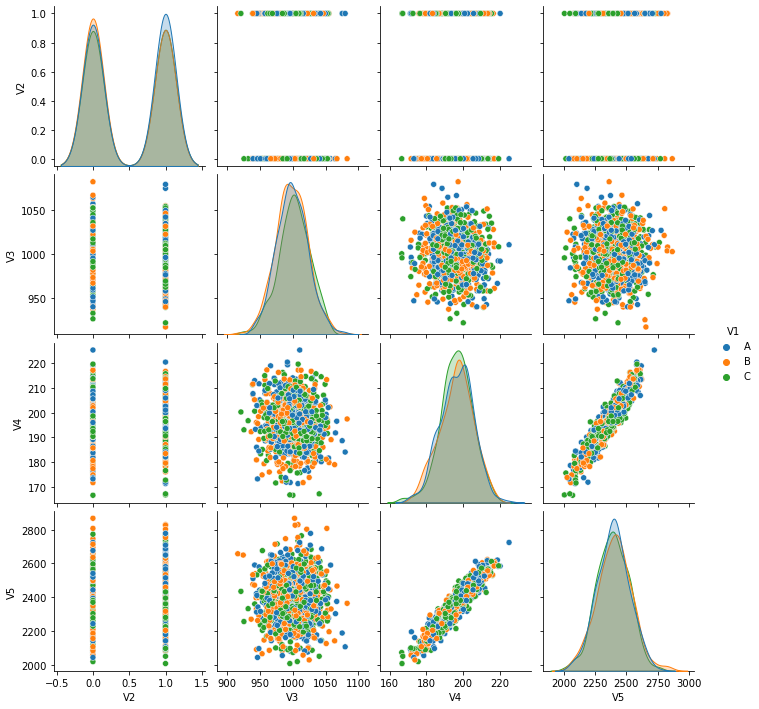

In [23]:
sns.pairplot(data, hue = 'V1', hue_order=['A', 'B', 'C'])
plt.show()

In [30]:
data.isna().sum()

V1      0
V2    159
V3    104
V4    413
V5    118
dtype: int64

2. Buscaremos decidir el mecanismo que dio origen a los valores faltante de cada columna. Para ello, ten en cuenta que:
* Para simplificar el análisis, si hay valores MAR, la dependencia sólo puede ser con la columna categórica sin valores faltantes, `V1`. Entonces, basta que solamente pruebes dependencia con esa variable. Te puede ser **muy útil** [esta pregunta de Stack Overflow](https://stackoverflow.com/questions/43321455/pandas-count-null-values-in-a-groupby-function/43322220).
* MNAR puede es difícil de estudiar si no tenemos conocimiento del tema o si no hay una variable que correlacione con la variable que queremos estudiar para usar de *proxy*. ¿Qué queremos decir con esto? Imaginate que tienes una planilla con sueldos mensuales de personas y vas a borrar valores con mayor probabilidad si son más altos. Pero no te diste cuenta que en otra planilla figuran el estimativo del sueldo anual, lo cual correlaciona fuertemente con el sueldo mensual. Entonces, si quieres ver si la probabilidad de borrar un valor estaba relacionada con ese valor, lo que puedes hacer es crear intervalos para la variables sin valores faltantes - es decir, crear rangos de sueldos anuales - y contar cuántas instancias que caen dentro de ese intervalo tienen valores faltantes en la variable borrada (sueldo mensual). Al principio es muy confuso, pero piénsalo un rato y vas a ver que tiene sentido.
* MCAR es un mecanismo que puede ser difícil de estudiar. Tal vez es más probable que llegues a él *por descarte* de los otros dos mecanismos.

**MAR con respecto a `V1`**

In [25]:
data.V2.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,39
1,B,52
2,C,68


In [26]:
data.V3.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,30
1,B,0
2,C,74


In [27]:
data.V4.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,139
1,B,147
2,C,127


In [29]:
data.V5.isnull().groupby([data['V1']]).sum().astype(int).reset_index(name='count')

,V1,count
0,A,34
1,B,44
2,C,40


Notar que la única variable que parece tener una dependencia fuerte en sus valores faltantes con `V1` es `V3`.

**MNAR**

Las únicas variables correlacionadas son `V4` y `V5`, ambas con valores faltantes. Entonces, podemos usar una para ver si los valores faltantes de la otra son **MNAR**.

Arranquemos estudiando los valores faltante en `V5`. Para ello, debemos binear `V4` y contar cuántos valores faltantes de `V5` caen en cada intervalo. Entonces, creamos los intervalos para `V4`

In [84]:
data.describe()

,V2,V3,V4,V5
count,1341.000000,1396.000000,1087.000000,1382.000000
mean,0.500373,999.686269,196.414056,2395.781409
std,0.500186,24.099044,8.986208,131.714318
min,0.000000,916.828247,166.654303,2005.861180
25%,0.000000,984.023781,190.708818,2306.219362
50%,1.000000,999.385885,196.753671,2397.870540
75%,1.000000,1015.946214,202.423761,2480.880485
max,1.000000,1082.767001,225.195704,2866.799351


In [32]:
data['V4-intervalos'] = pd.cut(data.V4, bins  = 15)
data

,V1,V2,V3,V4,V5,V4-intervalos
0,C,1.0,986.175237,184.258917,2224.638050,"(182.265, 186.168]"
1,C,1.0,994.130276,NaN,2570.213101,NaN
2,A,1.0,985.782622,196.893581,2309.238832,"(193.974, 197.876]"
3,A,1.0,1029.464887,192.063247,2349.259233,"(190.071, 193.974]"
4,A,1.0,1004.357092,NaN,2474.036357,NaN
...,...,...,...,...,...,...
1495,C,0.0,985.188653,190.366109,2302.000694,"(190.071, 193.974]"
1496,C,0.0,991.730134,193.553401,2277.045998,"(190.071, 193.974]"
1497,B,0.0,1032.150519,NaN,2347.760632,NaN
1498,C,1.0,984.522924,196.373516,2393.847484,"(193.974, 197.876]"


y contamos cuántas instancias por intervalo tienen valores faltantes en `V5`.

In [34]:
vf_V4V5 = data.V5.isnull().groupby([data['V4-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V4V5

,V4-intervalos,count
0,"(166.596, 170.557]",0
1,"(170.557, 174.46]",0
2,"(174.46, 178.363]",1
3,"(178.363, 182.265]",2
4,"(182.265, 186.168]",5
5,"(186.168, 190.071]",6
6,"(190.071, 193.974]",17
7,"(193.974, 197.876]",12
8,"(197.876, 201.779]",20
9,"(201.779, 205.682]",13


Pero en realidad lo que nos interesa es la frecuencia de estos valores faltantes, porque no todos los intervalos tienen la misma cantidad de instancias.

In [35]:
vf_V4V5['freq'] = vf_V4V5['count']/data.groupby([data['V4-intervalos']]).count()['V4'].values
vf_V4V5

,V4-intervalos,count,freq
0,"(166.596, 170.557]",0,0.000000
1,"(170.557, 174.46]",0,0.000000
2,"(174.46, 178.363]",1,0.062500
3,"(178.363, 182.265]",2,0.051282
4,"(182.265, 186.168]",5,0.060976
5,"(186.168, 190.071]",6,0.063830
6,"(190.071, 193.974]",17,0.104938
7,"(193.974, 197.876]",12,0.065217
8,"(197.876, 201.779]",20,0.109290
9,"(201.779, 205.682]",13,0.084416


Para que sea más fácil e informativo el gráfico, agregamos a este dataframe el punto medio de cada intervalo.

In [36]:
vf_V4V5["bin_centres"] = vf_V4V5["V4-intervalos"].apply(lambda x: x.mid)
vf_V4V5

,V4-intervalos,count,freq,bin_centres
0,"(166.596, 170.557]",0,0.000000,168.5765
1,"(170.557, 174.46]",0,0.000000,172.5085
2,"(174.46, 178.363]",1,0.062500,176.4115
3,"(178.363, 182.265]",2,0.051282,180.3140
4,"(182.265, 186.168]",5,0.060976,184.2165
5,"(186.168, 190.071]",6,0.063830,188.1195
6,"(190.071, 193.974]",17,0.104938,192.0225
7,"(193.974, 197.876]",12,0.065217,195.9250
8,"(197.876, 201.779]",20,0.109290,199.8275
9,"(201.779, 205.682]",13,0.084416,203.7305


y finalmente, graficamos

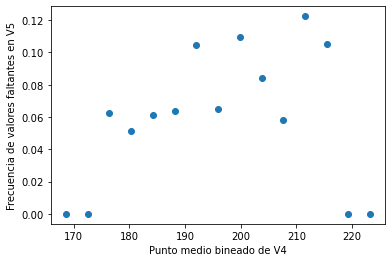

In [37]:
plt.scatter(vf_V4V5['bin_centres'], vf_V4V5['freq'])
plt.xlabel('Punto medio bineado de V4')
plt.ylabel('Frecuencia de valores faltantes en V5')
plt.show()

¿Te parece que da alguna información este gráfico? No te apures a sacar conclusiones. Vuelve a repetir los pasos, pero invirtiendo el rol de `V5` y `V4` - solamente tienes que copiar cada celda e intercalar los nombres. Una vez que hayas llegado al gráfico, ahora sí mira si puedes sacar alguna conclusión.

In [38]:
data['V5-intervalos'] = pd.cut(data.V5, bins  = 15)
data

,V1,V2,V3,V4,V5,V4-intervalos,V5-intervalos
0,C,1.0,986.175237,184.258917,2224.638050,"(182.265, 186.168]","(2178.049, 2235.445]"
1,C,1.0,994.130276,NaN,2570.213101,NaN,"(2522.424, 2579.82]"
2,A,1.0,985.782622,196.893581,2309.238832,"(193.974, 197.876]","(2292.841, 2350.236]"
3,A,1.0,1029.464887,192.063247,2349.259233,"(190.071, 193.974]","(2292.841, 2350.236]"
4,A,1.0,1004.357092,NaN,2474.036357,NaN,"(2465.028, 2522.424]"
...,...,...,...,...,...,...,...
1495,C,0.0,985.188653,190.366109,2302.000694,"(190.071, 193.974]","(2292.841, 2350.236]"
1496,C,0.0,991.730134,193.553401,2277.045998,"(190.071, 193.974]","(2235.445, 2292.841]"
1497,B,0.0,1032.150519,NaN,2347.760632,NaN,"(2292.841, 2350.236]"
1498,C,1.0,984.522924,196.373516,2393.847484,"(193.974, 197.876]","(2350.236, 2407.632]"


In [39]:
vf_V5V4 = data.V4.isnull().groupby([data['V5-intervalos']]).sum().astype(int).reset_index(name='count')
vf_V5V4

,V5-intervalos,count
0,"(2005.0, 2063.257]",0
1,"(2063.257, 2120.653]",1
2,"(2120.653, 2178.049]",0
3,"(2178.049, 2235.445]",4
4,"(2235.445, 2292.841]",9
5,"(2292.841, 2350.236]",26
6,"(2350.236, 2407.632]",39
7,"(2407.632, 2465.028]",58
8,"(2465.028, 2522.424]",79
9,"(2522.424, 2579.82]",79


In [40]:
vf_V5V4['freq'] = vf_V5V4['count']/data.groupby([data['V5-intervalos']]).count()['V5'].values
vf_V5V4

,V5-intervalos,count,freq
0,"(2005.0, 2063.257]",0,0.000000
1,"(2063.257, 2120.653]",1,0.040000
2,"(2120.653, 2178.049]",0,0.000000
3,"(2178.049, 2235.445]",4,0.049383
4,"(2235.445, 2292.841]",9,0.058824
5,"(2292.841, 2350.236]",26,0.134715
6,"(2350.236, 2407.632]",39,0.157895
7,"(2407.632, 2465.028]",58,0.254386
8,"(2465.028, 2522.424]",79,0.461988
9,"(2522.424, 2579.82]",79,0.612403


In [41]:
vf_V5V4["bin_centres"] = vf_V5V4["V5-intervalos"].apply(lambda x: x.mid)
vf_V5V4

,V5-intervalos,count,freq,bin_centres
0,"(2005.0, 2063.257]",0,0.000000,2034.1285
1,"(2063.257, 2120.653]",1,0.040000,2091.9550
2,"(2120.653, 2178.049]",0,0.000000,2149.3510
3,"(2178.049, 2235.445]",4,0.049383,2206.7470
4,"(2235.445, 2292.841]",9,0.058824,2264.1430
5,"(2292.841, 2350.236]",26,0.134715,2321.5385
6,"(2350.236, 2407.632]",39,0.157895,2378.9340
7,"(2407.632, 2465.028]",58,0.254386,2436.3300
8,"(2465.028, 2522.424]",79,0.461988,2493.7260
9,"(2522.424, 2579.82]",79,0.612403,2551.1220


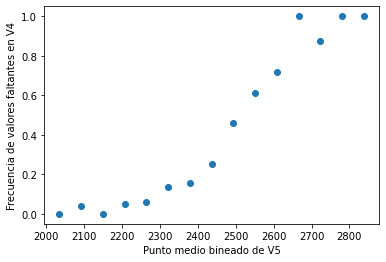

In [42]:
plt.scatter(vf_V5V4['bin_centres'], vf_V5V4['freq'])
plt.xlabel('Punto medio bineado de V5')
plt.ylabel('Frecuencia de valores faltantes en V4')
plt.show()

¿Has llegado a alguna conclusión? Entre `V4` y `V5`, ¿cuál es MNAR y cuál MCAR?¿Y `V2`?

## 1.2 Imputación de valores faltantes

Vamos a *imputar* los valores faltantes. Te recomendamos que:

1. Al tratarse de un dataset pequeño, puedes copiar el dataset, dejar a un lado el original y rellenar valores faltantes en la copia. De esta forma, podrás evaluar tu estrategia (ver punto siguiente) y/o comparar distintas estrategias.
1. Haz histogramas de las variables con y sin valores faltantes. Al imputar, ¿cambián las distribuciones?¿Esto está bien o mal?

**Ejercicio 1 - Challenge:** Comienza con una estrategia sencilla, imputar con el valor medio de cada columna usando Pandas. ¿Para cuáles columnas tendrá sentido esto, teniendo en cuenta lo visto en el punto anterior? 

**Ejercicio 2:** Propone - e implementa - una estrategia que consideres mejor, incorporando la información del punto 1. En el siguiente encuentro, te daremos el dataset sin valores faltantes, por lo que podrás comparar tus resultados. ¡Ten en cuenta que es muy raro que esto se pueda hacer! Lo que nos lleva a...

**Ejercicio 3:** ¿Se te ocurre algún mecanismo de evaluación de tu estrategia? Pista: considera lo que vimos sobre Machine Learning en el Bloque 1 de la carrera. 

Por las dudas, comenzamos volviendo a cargar los datos:

In [85]:
data = pd.read_csv('DS_Bitácora_19_Data_con_VF.csv')
data.isna().sum()

V1      0
V2    159
V3    104
V4    413
V5    118
dtype: int64

In [48]:
data_copy = data.copy()
data_copy.fillna(data_copy.mean(),inplace = True)
data_copy.isna().sum()

V1    0
V2    0
V3    0
V4    0
V5    0
dtype: int64

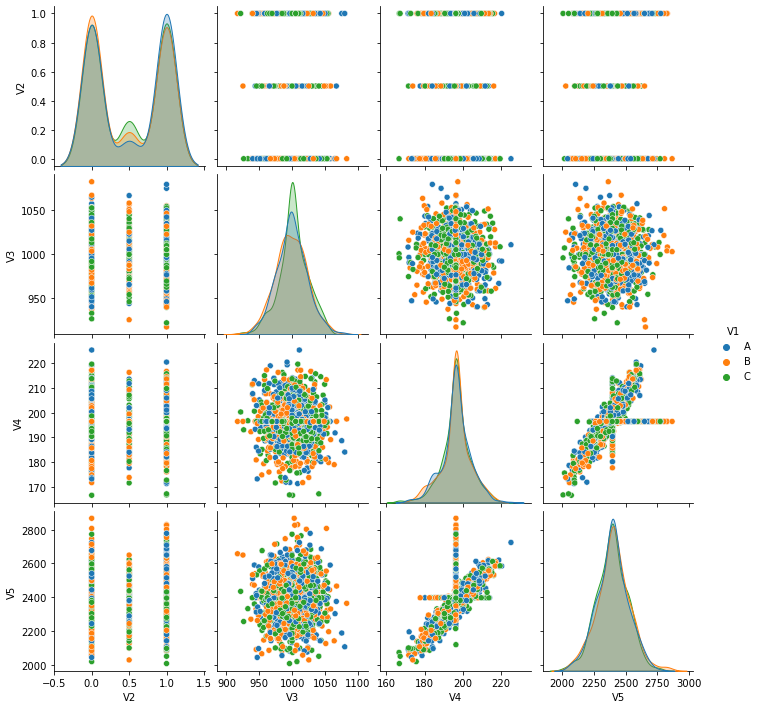

In [49]:
sns.pairplot(data_copy, hue = 'V1', hue_order=['A', 'B', 'C'])
plt.show()

### 1.2.2 Distrofia

La Distrofia Muscular de Duchenne (DMD) es una enfermedad que se transmite genéticamente de madres a hijos e hijas. Mientras que los varones mueren a temprana edad, las mujeres pueden llevar la enfermedad sin saberlo y sin síntomas. Se estima que 1 de cada 3300 mujeres son portadoras de la enfermedad.

Si bien portadoras de DMD no suelen tener síntomas, tienden a exhibir elevados niveles de enzimas o proteínas del suero, como creatina quinasa (CK, por sus siglas en inglés), hemopexina (H), lactato deshidrogenasa (LD) y piruvato quinasa (PK, por sus siglas en inglés). Los niveles de estas enzimas también pueden variar con la edad y la estación. En un estudio llevado a cabo a finales de la década del 70 se midieron esas enzimas en portadoras y no-portadoras de la enfermedad, para estudiar la posibilidad de informar a mujeres la posibilidad de que sean portadoras. Los resultados los pueden encontrar en el archivo `DS_Bitácora_19_Distrofia.csv`.

En este dataset hay valores faltantes en dos de sus columnas. Estos valores faltantes no aparecerán inmediatamente como `NaN` cuando abran el dataset con Pandas, sino que están guardados con un valor en particular. Abre y explora el dataset para descubrir ese valor. Luego, investiga como puedes pasar como argumento a la función de Pandas `read_csv` para que cuando cargue los datos ya los reconozca como valores faltantes. ¿Qué tipo de valores faltantes son?¿Están asociados a los valores de otras columnas? Luego, imputa los valores faltantes. 

In [ ]:
## COMPLETAR

## 2. Valores Atípicos

Los datos que usaremos en esta sección, "DS_Bitácora_19_Data_VA1.csv" y "DS_Bitácora_19_Data_VA2.csv", fueron simulados con algún criterio desconocido. Uno de los archivos contiene "valores atípicos" y el otro no. El objetivo de esta sección es que decidan en cuál de ellos hay outliers y apliquen las técnicas vistas para detectarlos.

Empieza por uno de los archivos, y, una vez que hayas terminado, repite para el otro.


1. Exploración de datos.
    1. Abrir los datos y explorarlos. Para ello, recomendamos hacer un `distplot` y un `boxplot`. ¿Hay valores atípicos? Si los hay, ¿en qué región del dominio?
    2. Calcular algunos estadísticos sobre la muestra: valor medio, desviación estándar, cuartiles, máximo, mínimo, etc.
2. Manejo de Outliers
    1. Aplicar la técnica del rango interquartílico y la regla de las tres sigmas para seleccionar outliers. ¿Cuántos valores selecciona cada técnica?¿Seleccionan los mismos valores?
    2. Supongamos que seleccionamos outliers y los descartamos. ¿Qué pasa si volvemos a aplicar estas técnicas?

**1. Exploración de Datos**

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [59]:
data = pd.read_csv('DS_Bitácora_19_Data_VA1.csv')
#data = pd.read_csv('DS_Bitácora_19_Data_VA2.csv')
data.head()

,Datos
0,2.370556
1,3.437876
2,6.300131
3,5.403170
4,5.722120


/Users/laura.grajales/.pyenv/versions/miniconda3-4.7.12/envs/clases-curso65/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

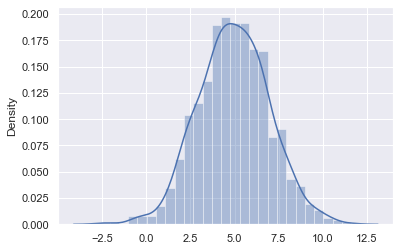

In [60]:
sns.distplot(data.values)

/Users/laura.grajales/.pyenv/versions/miniconda3-4.7.12/envs/clases-curso65/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

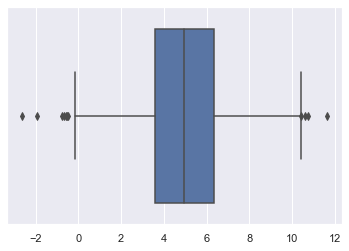

In [61]:
sns.boxplot(data.values)

In [62]:
data.describe()

,Datos
count,1000.000000
mean,4.952783
std,2.008023
min,-2.619781
25%,3.607388
50%,4.960488
75%,6.332730
max,11.628151


**2. Manejo de outliers**

No hay una sola forma de aplicar estas reglas.

1. Rango Intercuartílico

In [63]:
q25,q75 = np.percentile(data.Datos.values, [25,75])
iqr = q75 - q25
minimo = q25 - 1.5*iqr
maximo = q75 + 1.5*iqr
print(q25,q75,iqr, minimo, maximo)

3.60738811223393 6.33273017886759 2.72534206663366 -0.4806249877165598 10.42074327881808


In [64]:
data.Datos < minimo

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Datos, Length: 1000, dtype: bool

In [65]:
mascara_outliers = (data.Datos < minimo) | (data.Datos > maximo)
mascara_outliers.sum()

11

In [66]:
data[mascara_outliers]

,Datos
181,-1.925574
195,-0.486077
309,-0.537363
426,-2.619781
495,-0.601945
525,-0.776018
534,10.626484
540,10.424289
624,11.628151
649,-0.691831


2. Regla de las tres sigmas

In [67]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data.Datos < minimo, data.Datos > maximo)

In [68]:
mascara_outliers.sum()

3

In [69]:
data[mascara_outliers]

,Datos
181,-1.925574
426,-2.619781
624,11.628151


In [70]:
data = pd.read_csv('DS_Bitácora_19_Data_VA2.csv')
data.head()

,Datos
0,2.370556
1,3.437876
2,6.300131
3,5.403170
4,5.722120


/Users/laura.grajales/.pyenv/versions/miniconda3-4.7.12/envs/clases-curso65/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

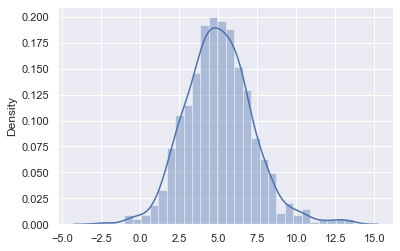

In [71]:
sns.distplot(data.values)

/Users/laura.grajales/.pyenv/versions/miniconda3-4.7.12/envs/clases-curso65/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

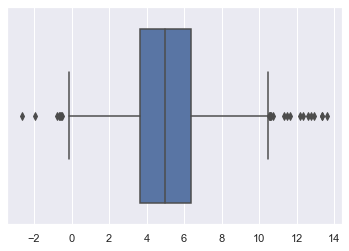

In [72]:
sns.boxplot(data.values)

In [73]:
data.describe()

,Datos
count,1000.000000
mean,5.059634
std,2.162233
min,-2.619781
25%,3.630454
50%,4.995364
75%,6.371097
max,13.613645


In [74]:
q25,q75 = np.percentile(data.Datos.values, [25,75])
iqr = q75 - q25
minimo = q25 - 1.5*iqr
maximo = q75 + 1.5*iqr
print(q25,q75,iqr, minimo, maximo)

3.6304538110419 6.371096932721359 2.7406431216794593 -0.48051087147728877 10.482061615240548


In [75]:
mascara_outliers = (data.Datos < minimo) | (data.Datos > maximo)
mascara_outliers.sum()

23

In [76]:
data[mascara_outliers]

,Datos
27,12.908427
86,12.633931
112,13.358959
181,-1.925574
195,-0.486077
231,10.587165
251,10.519530
309,-0.537363
388,12.166490
399,10.592049


In [78]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data.Datos < minimo, data.Datos > maximo)

In [79]:
mascara_outliers.sum()

11

In [80]:
data[mascara_outliers]

,Datos
27,12.908427
86,12.633931
112,13.358959
181,-1.925574
388,12.166490
426,-2.619781
475,12.788713
624,11.628151
662,13.613645
899,12.367070


## 3. Escalado de datos

Seguiremos usando los datos de la sección anterior:

1. Agregar al dataframe una columna que se llame "Datos_Reescalados" y que contenga los datos reescalados por Z-Score. ¿Cuál es el valor medio de los datos reescalados?¿Y su desviación estándar? **Nota:** Para reescalar los datos, pueden hacerlo "a mano" o utilizar la clase `StandardScaler` de Scikit-Learn. No te olvides que las herramientas de preprocesamiento de datos de Scikit-learn tienen los mismos métodos (crear el objeto, fitearlo, transfromar los datos). Si necesitás ayuda, podés consultar la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
2. Realizá, en un mismo gráfico, un histograma de los datos reescaleados y un histograma de los datos crudos. ¿Qué similitudes y qué diferencias tiene con la distribución de datos crudos?
3. Aplica la regla de las tres sigmas utilizando los datos reescalados.
    

In [ ]:
valor_medio = data.Datos.mean()
std = data.Datos.std()
data['Datos_Reescalados'] = (data.Datos - valor_medio)/std
data.head()

,Datos,Datos_Reescalados
0,2.370556,-1.285955
1,3.437876,-0.754427
2,6.300131,0.670982
3,5.403170,0.224294
4,5.722120,0.383131


In [ ]:
print(data.Datos_Reescalados.mean(), data.Datos_Reescalados.std())

1.1368683772161603e-16 0.9999999999999999


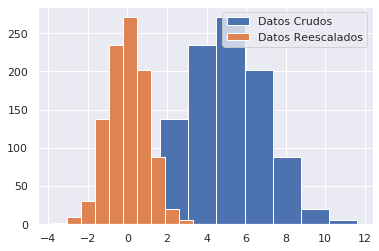

In [ ]:
data.Datos.hist(label = 'Datos Crudos')
data.Datos_Reescalados.hist(label = 'Datos Reescalados')
plt.legend()
plt.show()

In [ ]:
# sns.distplot(data.Datos_Reescalados.values, label = 'Datos Reescalados')
# sns.distplot(data.Datos.values, label = 'Datos Crudos')
# plt.legend()
# plt.show()

In [ ]:
mascara_outliers = np.logical_or(data.Datos_Reescalados < -3, data.Datos_Reescalados > 3)
print(mascara_outliers.sum())

3


In [ ]:
data[mascara_outliers]

,Datos,Datos_Reescalados
181,-1.925574,-3.425438
426,-2.619781,-3.771155
624,11.628151,3.324349


## 4. Encoders

Elige un dataset de los que hayamos usado hasta el momento - puede ser el de Titanic, el de Vinos, el del proyecto o inclusive uno que hayas visto y que te interese - y haz los siguiente ejercicios:

1. ¿De qué tipo es cada atributo?
2. Lleva todos los atributos que te interesen a una forma numérica. ¿Cómo creció tu dataset?
3. Si hay una tarea de regresión o clasificación bien definida sobre ese dataset que te interese explorar, hazlo. Para ello, entrena un modelo de árboles de decisión (no te olvides de seguir todos los pasos de un flujo de Machine Learning: elegir una métrica de evaluación, hacer una `train_test_split`, etc.). ¿Cómo cambia el desempeño del modelo con la incorporación de estos atributos? Recuerda que si utilizas un modelo de vecinos más cercanos, es importante escalar los datos antes.

